In [1]:
# 📦 Basic
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt

# 🖼️ Image processing
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# 🧠 Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [2]:
# 🧭 Path to dataset (adjust to your real location)
dataset_path = "./archive"

# 🗂️ Training and testing folders inside dataset
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

# 🏷️ Tumor categories
LABELS = ['glioma', 'meningioma', 'pituitary', 'notumor']


In [3]:
# 🔀 Create a Combined/ directory with all images
combined_dir = os.path.join(dataset_path, "Combined")
os.makedirs(combined_dir, exist_ok=True)

for label in LABELS:
    label_dir = os.path.join(combined_dir, label)
    os.makedirs(label_dir, exist_ok=True)

    # 📁 Copy training images
    for img in os.listdir(os.path.join(train_dir, label)):
        src = os.path.join(train_dir, label, img)
        dst = os.path.join(label_dir, f"train_{img}")
        shutil.copy(src, dst)

    # 📁 Copy testing images
    for img in os.listdir(os.path.join(test_dir, label)):
        src = os.path.join(test_dir, label, img)
        dst = os.path.join(label_dir, f"test_{img}")
        shutil.copy(src, dst)

print("✅ Merged training and testing data into Combined/")


✅ Merged training and testing data into Combined/


In [4]:
# 🔄 Set target image size
IMG_SIZE = (128, 128)

data = []
labels = []

# 📥 Load and preprocess each image
for label in LABELS:
    folder = os.path.join(combined_dir, label)
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(IMG_SIZE)
            data.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"❌ Could not process {img_path}: {e}")


In [5]:
# 🧮 Convert to NumPy arrays
X = np.array(data) / 255.0  # Normalize pixel values to [0, 1]
y = np.array(labels)

print(f"✅ Loaded {len(X)} images.")
print(f"📐 Input shape: {X.shape}")


✅ Loaded 7023 images.
📐 Input shape: (7023, 128, 128, 3)


In [6]:
# 🧬 Encode labels to integers
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# 🔀 Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"🧪 Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


🧪 Training samples: 5618, Testing samples: 1405


In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(LABELS), activation='softmax')  # 4 output classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


c:\Users\thavi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,836 (28.20 MB)

 Trainable params: 7,392,836 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 🏋️ Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 42s 223ms/step - accuracy: 0.6265 - loss: 0.8971 - val_accuracy: 0.8434 - val_loss: 0.4063
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 39s 221ms/step - accuracy: 0.8320 - loss: 0.4271 - val_accuracy: 0.8612 - val_loss: 0.3129
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - accuracy: 0.8965 - loss: 0.2676 - val_accuracy: 0.9238 - val_loss: 0.2302
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 39s 224ms/step - accuracy: 0.9198 - loss: 0.1959 - val_accuracy: 0.9260 - val_loss: 0.2179
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.9451 - loss: 0.1491 - val_accuracy: 0.9423 - val_loss: 0.1808
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 47s 268ms/step - accuracy: 0.9604 - loss: 0.1078 - val_accuracy: 0.9537 - val_loss: 0.1376
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 43s 242ms/step - accuracy: 0.9751 - loss: 0.0691 - val_accuracy: 0.9488 - val_loss: 0.1666
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 42s 239ms/step - accuracy: 0.9778 - loss: 0

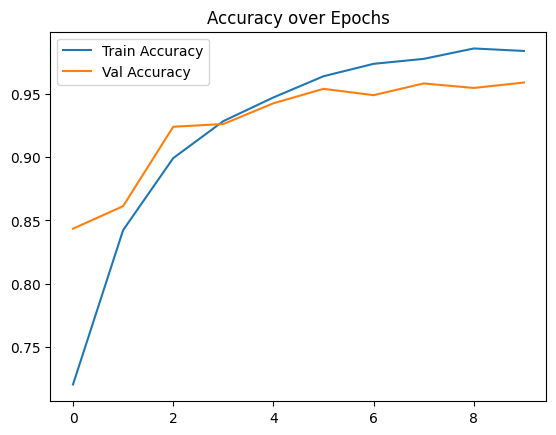

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
              precision    recall  f1-score   support

      glioma       0.95      0.94      0.95       324
  meningioma       0.91      0.92      0.92       329
   pituitary       0.98      0.98      0.98       400
     notumor       0.99      0.99      0.99       352

    accuracy                           0.96      1405
   macro avg       0.96      0.96      0.96      1405
weighted avg       0.96      0.96      0.96      1405



In [9]:
# 📊 Accuracy and loss plots
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

# 🧾 Classification report
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_labels, target_names=LABELS))


In [10]:
# 💾 Save model and label encoder
model.save("brain_tumor_cnn_model.h5")

import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

print("✅ Model and label encoder saved.")


✅ Model and label encoder saved.
